##  Intro to tonal representation of data, and RTcmix 
### (1) Read in the data file ! 
### (2) No Rhythm ! time determines pitches
### (3) Got Rhythm! pitches determine time
### (4) Swelling chords
### (5) Chord Sweeps

In [41]:
# import what you need ! 

import sys
sys.path.append('../2_modules/')

import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import pandas as pd
import subprocess as sp
from subprocess import Popen

# our modules: 
import notepicker
#import makeDataChord_v2 as mDc # read in below. 
#import writeCmixSco_GRAN_v2 as wRT_gran
import writeCmixSco_WT_ac as wRT_wt
# _ac stands for autocheck

%matplotlib inline

# ======================================================
# autocheck for your RTcmix installation type: 
cmixStatus, cmixResult = sp.getstatusoutput("CMIX")
if cmixStatus == 0:
    cmixInstalled = True
    print("CMIX found.")
else:
    cmixInstalled = False
    print("CMIX not found, using pyGoRTcmix instead.")
# ======================================================

%matplotlib inline

CMIX found.


## (1) Read in the data ! 

In [42]:
# READ IN THE DATA FILE ! ! !
datafilename = '../0_data_nogit/ba_y20/y2020-02-13_chris0_37s.pkl'      #breathalyzer/pizzadevils_120s.pkl'

breath = pd.read_pickle(datafilename) # np.loadtxt(datafilename)
print(breath[0:5])
time = breath.time_s
p1 = temp_C = breath.temp_C
p2 = humidity = breath.hum

# put the data into a dictionary: 
# (very useful, but we will also work with pandas)
data_dict = {}
data_dict['time_o'] = time  # the _o indicates these are the original values, un-re-sampled
data_dict['p1_o'] = p1

      hum  temp_C  time_s
0  30.053   25.29  0.0000
1  29.986   25.30  0.3406
2  29.987   25.31  0.6763
3  30.191   25.32  1.0499
4  30.800   25.34  1.4291


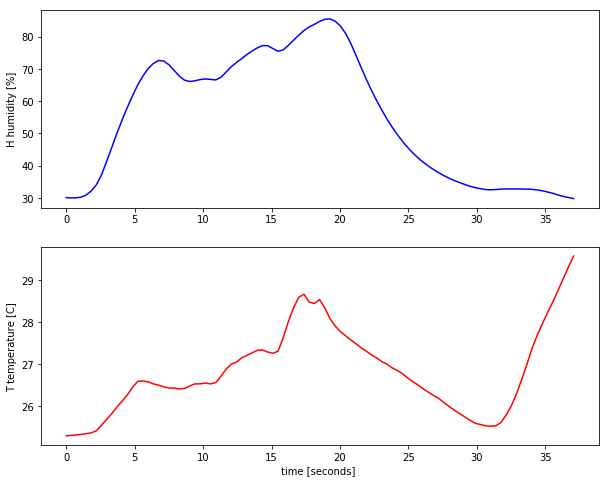

In [43]:
# PLOT THE DATA AS CURVES... 
fig = plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(time,humidity,'b-')
#plt.xlabel('time')
plt.ylabel('H humidity [%]')

plt.subplot(2,1,2)
plt.plot(time,temp_C,'r-')
plt.xlabel('time [seconds] ')
plt.ylabel('T temperature [C]')

plt.show()

## (2) No Rhythm ! time determines pitches

(1) Decide the times at which you want to sample the data <br>
(2) Interpolate the y-values to a range of frequency <br>
(3) Interpolate the frequency values at each time <br>
(4) write RTcmix Wavetable score <br>

In [44]:
# (1) Decide the times at which you want to sample the data
ind_end = len(time)-1
duration_data = time[ind_end]
print('data duration = ', str(duration_data))
t_start = 0
t_end = time[ind_end] 
n_notes = 100
times = np.linspace(t_start,t_end,n_notes)

# stretch or shrink time, for the duration of the score-- 
# but you'll see why we need to keep the original times... 

stretch = 0.2
times_sco = times*stretch
print('score duration = ', str(times_sco[-1]))
dt = times_sco[2]-times_sco[1]
print(dt)

data duration =  37.0645
score duration =  7.4129000000000005
0.0748777777777778


In [45]:
# (2) Interpolate the y-values to a range of frequency 
# NOTE: we will use interpolate all the time ! play with it to understand what it is doing! 
p1_data_range = np.linspace(min(p1),max(p1),40) # the number of points doesnt matter here ! 
f_min = 220.
f_max = 800.
freq_range = np.linspace(f_min,f_max,40)

# np.interp(x, xp, yp) : 
# x is the array of discrete sampling values, xp is original x, yp is original y
# returns the y values at 

p1_f = np.interp(p1,p1_data_range,freq_range)
print(p1[0:10])
print(p1_f[0:10])


0    25.29
1    25.30
2    25.31
3    25.32
4    25.34
5    25.36
6    25.41
7    25.54
8    25.68
9    25.82
Name: temp_C, dtype: float64
[220.         221.35198135 222.7039627  224.05594406 226.75990676
 229.46386946 236.22377622 253.7995338  272.72727273 291.65501166]


In [46]:
# (3) Interpolate the frequency values at each time
pitches = np.interp(times,time,p1_f)
print(pitches[0:10])

[220.         221.48806103 222.96624483 224.57838692 227.24791432
 230.59695973 238.95067602 256.49747184 275.19232442 294.1865023 ]


Text(0,0.5,'pitches (T temperature)')

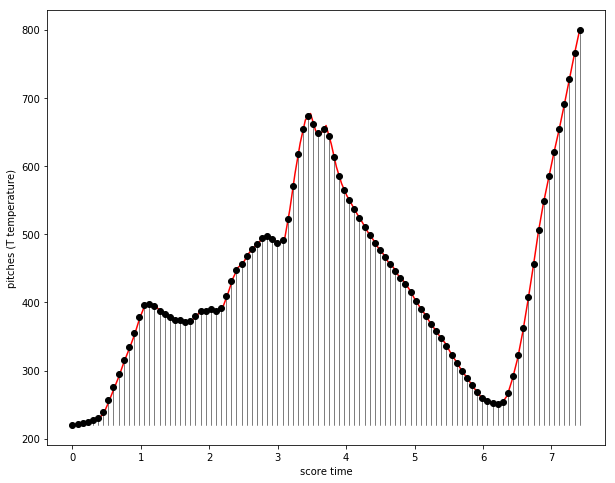

In [47]:
# plot the results: 

fig = plt.figure(figsize=(10,8))
time_tmp = np.linspace(times_sco[0],times_sco[-1],len(p1_f))
plt.plot(time_tmp,p1_f,'r-')
plt.plot(times_sco,pitches,'ko')
for ind,t in enumerate(times_sco):
    plt.plot([t,t],[f_min,pitches[ind]],'k-', linewidth=0.5)
    
plt.xlabel('score time')
plt.ylabel('pitches (T temperature)')

In [48]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_noRhythm1'

tones_dict = {}
tones_dict['times'] = np.asarray(times_sco)
tones_dict['notes'] = np.asarray(pitches)
tones_dict['durs'] = np.ones(len(pitches))*dt*1.0 # the 0.8 makes for more discrete pitches
tones_dict['amps'] = np.ones(len(pitches))*2000
tones_dict['pans'] = np.ones(len(pitches))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_noRhythm1.sco
CMIX found.
rtoutput("test_noRhythm1.wav")



In [49]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])
print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

sp.run(['mv', score_name, '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)

CMIX < test_noRhythm1.sco
/Users/ben/githole/datamovies/1_codes
phrygian_c.sco     scale1_RT.sco      test_noRhythm1.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_noRhythm1.wav


CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)

## 3) Got Rhythm ! pitches determine time !  

(1) Define the frequencies that we want to use ! <br>
(2) Interpolate the y values to this range of frequencies. <br>
(3) Find where in time these values occur, use these as our start times and durations.  <br>
(4) Generate the score. <br>

In [50]:
n_octaves_total = 2.0
root_note  = 110.0
ints_per_oct = 12

# chromatic scale of n octaves: 
intervals = np.linspace(0,n_octaves_total,int(n_octaves_total*ints_per_oct))
pitches = root_note*(2**intervals)
print(pitches)

# or... major scales of n octaves, etc... 



[110.         116.83398945 124.09255538 131.80207552 139.99056637
 148.68778505 157.92533737 167.73679273 178.15780612 189.22624765
 200.98234021 213.4688056  226.73101985 240.81717802 255.77846943
 271.66926363 288.54730802 306.47393766 325.51429819 345.73758257
 367.21728251 390.03145556 414.26300879 440.        ]


Text(0,0.5,'pitches (T temperature)')

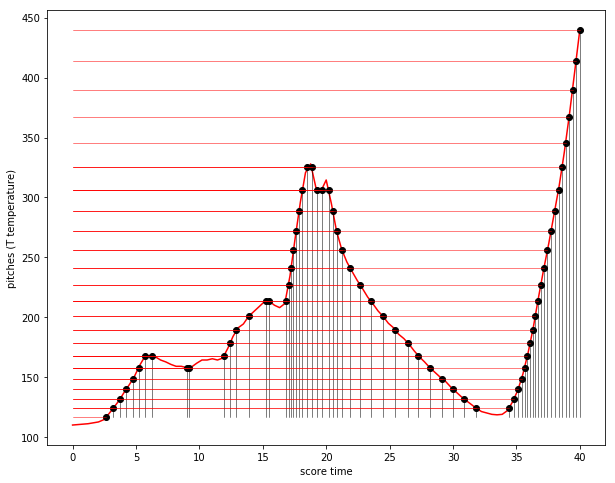

In [51]:
# (2) Interpolate the y-values to a range of frequency (using notepicker !)
reload(notepicker)
p1_in_freq = notepicker.interpvals_to_freqs(p1,pitches)

# (3) Find where in time these values occur, use these as our start times and durations.
dur_sound = 40.0
time = np.linspace(0,dur_sound,len(p1_in_freq))
scale_note_dur = 0.8
times, notes, durs = notepicker.findroots(time,p1_in_freq,pitches)


# plot the results: 
fig = plt.figure(figsize=(10,8))

time_tmp = np.linspace(time[0],time[-1],len(p1_in_freq))
plt.plot(time_tmp,p1_in_freq,'r-')
plt.plot(times,notes,'ko')

for ind,t in enumerate(times):
    plt.plot([t,t],[min(notes),notes[ind]],'k-',linewidth=0.5)
    plt.plot([0,t],[notes[ind],notes[ind]],'r-',linewidth=0.5)
    
plt.xlabel('score time')
plt.ylabel('pitches (T temperature)')

In [52]:
# (4) write RTcmix Wavetable score
reload(wRT_wt)
base_name = 'test_gotRhythm1'
trim = -1
tones_dict = {}
tones_dict['times'] = np.asarray(times[:trim])
tones_dict['notes'] = np.asarray(notes[:trim])
tones_dict['durs'] = np.asarray(durs[:trim]) 
tones_dict['amps'] = np.ones(len(notes[:trim]))*2000
tones_dict['pans'] = np.ones(len(notes[:trim]))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_gotRhythm1.sco
CMIX found.
rtoutput("test_gotRhythm1.wav")



In [36]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])
print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

sp.run(['mv', score_name, '../3_output_nogit'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)

CMIX < test_gotRhythm1.sco
/Users/ben/githole/datamovies/1_codes
phrygian_c.sco      scale1_RT.sco       test_gotRhythm1.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_gotRhythm1.wav


CompletedProcess(args='mv *.wav ../3_output_nogit/', returncode=0)

## (4) Swelling chords

In [53]:
# OR USE OTHER MUSICAL STRUCTURES ! 
modes = {
    'ionian':[2,2,1,2,2,2,1],
    'dorian':[2,1,2,2,2,1,2],
    'phrygian':[1,2,2,2,1,2,2],
    'lydian':[2,2,2,1,2,2,1],
    'mixolydian':[2,2,1,2,2,1,2],
    'aeolian':[2,1,2,2,1,2,2],
    'lochrian':[1,2,2,1,2,2,2]
}

intervals = [0] + modes['phrygian'] + modes['phrygian'] + modes['phrygian'] + modes['phrygian'] # + modes['mixolydian']
print(intervals)
elements = np.cumsum(intervals[:-1])
print(elements)
#indexes = np.array(x)

C4 = 440.0 * 2**(3/12-1)
print(C4)

def notename2freq(k,v,f0):
    #freqs = f0*2**(v+k/12)
    freqs = f0*2**(v+k/12)
    return freqs

pitches = notename2freq(elements,-1,C4)
print(pitches)

[0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2]
[ 0  1  3  5  7  8 10 12 13 15 17 19 20 22 24 25 27 29 31 32 34 36 37 39
 41 43 44 46]
261.6255653005986
[ 130.81278265  138.59131549  155.56349186  174.61411572  195.99771799
  207.65234879  233.08188076  261.6255653   277.18263098  311.12698372
  349.22823143  391.99543598  415.30469758  466.16376152  523.2511306
  554.36526195  622.25396744  698.45646287  783.99087196  830.60939516
  932.32752304 1046.5022612  1108.73052391 1244.50793489 1396.91292573
 1567.98174393 1661.21879032 1864.65504607]


In [54]:
reload(notepicker)
dur = 20.0
scale_note_dur = 1.0

p1_freq = notepicker.interpvals_to_freqs(p1,pitches)

times, notes, durs = notepicker.findroots(time,p1_freq,pitches)


print(time[-1])

print(len(pitches))
print(len(time))
print(len(p1_freq))
print(len(times))
print(len(notes))

40.0
28
99
99
71
71


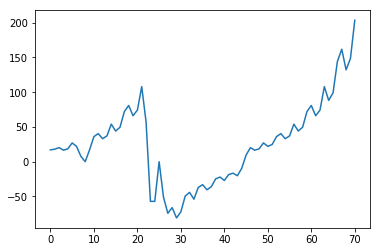

In [55]:
# development

grad_notes = np.gradient(notes)
#print(grad_notes)
#print(len(grad_notes))
#plt.plot(notes)
plt.plot(grad_notes)

In [56]:
# run makeDataChord
import makeDataChord_v2 as mDc
reload(mDc)

ch_notes, ch_times, ch_durs = mDc.makeDataChord(pitches,time,times,notes)
print(len(ch_durs))



48


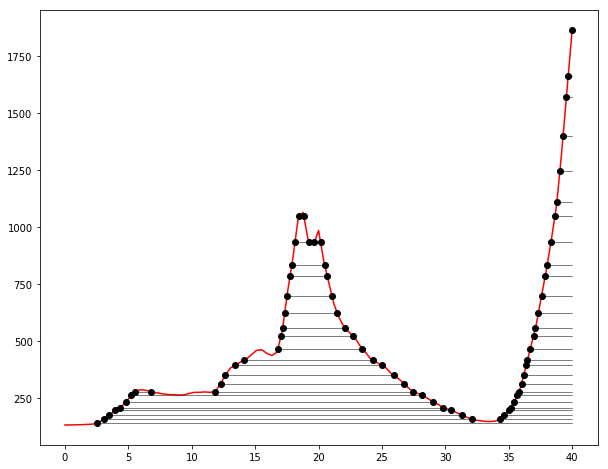

In [57]:
# plot the results: 
fig = plt.figure(figsize=(10,8))

plt.plot(time,p1_freq, 'r-')
plt.plot(times,notes,'ko')


for i in range(len(ch_notes)):
    
    plt.plot([ch_times[i],ch_times[i]+ch_durs[i]],[ch_notes[i],ch_notes[i]],'k-', linewidth=0.5)

In [58]:
reload(wRT_wt)
base_name = 'test_dataChords'
tones_dict = {}
tones_dict['times'] = np.asarray(ch_times)
tones_dict['notes'] = np.asarray(ch_notes)
tones_dict['durs'] = np.asarray(ch_durs)
tones_dict['amps'] = np.ones(len(ch_notes))*2000
tones_dict['pans'] = np.ones(len(ch_notes))*0.5

score_name = wRT_wt.writesco(tones_dict,base_name)

test_dataChords.sco
CMIX found.
rtoutput("test_dataChords.wav")



In [59]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal (this does not work in a script!)
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])

print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav



CMIX < test_dataChords.sco
/Users/ben/githole/datamovies/1_codes
phrygian_c.sco      scale1_RT.sco       test_dataChords.sco test_gotRhythm1.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_dataChords.wav


In [60]:
sp.run(['mv', score_name, '../3_output_nogit/'])
sp.run('mv *.wav ../3_output_nogit/', shell=True)
sp.run('mv *.sco ../3_output_nogit/', shell=True)

CompletedProcess(args='mv *.sco ../3_output_nogit/', returncode=0)

## (5) Chord Sweep

In [70]:
from matplotlib import gridspec
from matplotlib import cm
import pitches as ptch # "pitches" is used above as a variable name

In [85]:
# (2) Interpolate the y-values to a range of frequency 
# NOTE: we will use interpolate all the time ! play with it to understand what it is doing! 
p1_data_range = np.linspace(min(p1),max(p1),40) # the number of points doesnt matter here ! 
f_min = 220.
f_max = 800.
freq_range = np.linspace(f_min,f_max,40)

# np.interp(x, xp, yp) : 
# x is the array of discrete sampling values, xp is original x, yp is original y
# returns the y values at 

p1_f_4cs = np.interp(p1,p1_data_range,freq_range)
print(p1[0:10])
print(p1_f[0:10])

0    25.29
1    25.30
2    25.31
3    25.32
4    25.34
5    25.36
6    25.41
7    25.54
8    25.68
9    25.82
Name: temp_C, dtype: float64
[220.         221.35198135 222.7039627  224.05594406 226.75990676
 229.46386946 236.22377622 253.7995338  272.72727273 291.65501166]


In [90]:
Nw = 16 # number of weight functions
base_name = 'test_BAdata'
base_name = base_name + '_chSweep_Nwts' + str(Nw)  

# define the data: 
data = p1 #p1_f_4cs # note that it was interpolated to frequency above. 

lo = min(data)
hi = max(data)
# half width of each "bin function"-- there must be a word for this. 
hw = (hi-lo)/((Nw-1))
print('half width, hw = ', str(hw))
centers = np.linspace(lo,hi,Nw)
print(centers)

up = np.linspace(0,1,20)
down = np.flip(up[:-1], axis=0)
yWF = np.hstack((up,down)) # weighting function
print(len(yWF))

#extra_W = [1,2,3,4,5]
extra_W = np.linspace(1,Nw,Nw)
env_ra = np.zeros((Nw,len(data)))
env_tot = np.zeros(len(data))


half width, hw =  0.2859999999999999
[25.29  25.576 25.862 26.148 26.434 26.72  27.006 27.292 27.578 27.864
 28.15  28.436 28.722 29.008 29.294 29.58 ]
39


#### Now turn it into sound: 
#### 1) pick pitches 
#### 2) run rtCmix wavetable

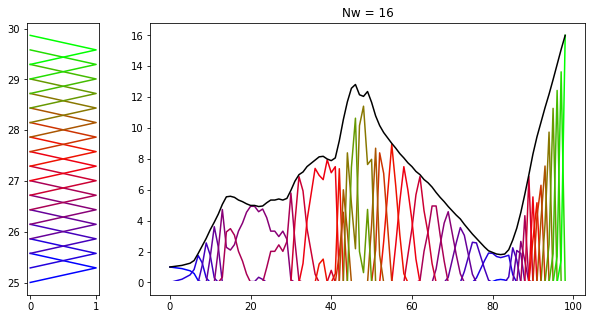

In [91]:
saveas = '.png'
figname = base_name + saveas

fig = plt.figure(figsize=(10, 5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 6]) 

cmap = cm.get_cmap('brg')
colors = cm.brg(np.linspace(0,1,Nw))

ax0 = plt.subplot(gs[0])
#plt.subplot(2,1,1)
for i,c in enumerate(centers):
    xWF = np.linspace(c-hw,c+hw,len(yWF))
    #plt.plot(xWF,yWF)
    ax0.plot(yWF,xWF, color=colors[i])
    
    for j,val in enumerate(data):
        env_ra[i,j] = np.interp(val,xWF,yWF)*extra_W[i]

env_tot = np.sum(env_ra,0)

ax1 = plt.subplot(gs[1])
#plt.subplot(2,1,2)
for i in range(Nw):
    #plt.plot(env_ra[i,:])
    ax1.plot(env_ra[i,:],color=colors[i])

#plt.plot(env_tot[:], 'k')
ax1.plot(env_tot[:], 'k')

ax1.plot(np.zeros(len(env_tot)), 'w',linewidth=3)
ttltext = 'Nw = '+str(Nw) #  + ', '
ax1.set_title(ttltext)

fig.savefig(figname)

In [92]:
# Pick the notes that become the oscillators 
# modulated by each amplitude envelope

reload(ptch)

NameFreq_dict = ptch.pitch_dict()
#print(NameFreq_dict.items())
modes_dict = ptch.modes()
print(modes_dict)

modes8 = modes_dict['modes8']
#mode = modes7['dorian']
mode = modes8['21']

intervals = [0] + mode  + mode
N_intv = len(intervals)
print(N_intv,Nw)
if len(intervals) != Nw:
    if Nw>N_intv:
        print('N weights > N intervals: will probably break')
    elif Nw<N_intv:
        print('N weights < N intervals: will work but you won\'t hit the high notes.')


print(intervals)
elements = np.cumsum(intervals[:-1])
print(elements)

D2 = NameFreq_dict['D2']

freqs = ptch.note2freq(elements,0,D2)
print(freqs)

# Print out the note names ! 
for find_freq in freqs:
    for notename, freq in NameFreq_dict.items():
        freq1 = np.round(freq,0)
        #print(freq1)
        if freq1 == np.round(find_freq,0):
            print(notename)

{'modes7': {'ionian': [2, 2, 1, 2, 2, 2, 1], 'dorian': [2, 1, 2, 2, 2, 1, 2], 'phrygian': [1, 2, 2, 2, 1, 2, 2], 'lydian': [2, 2, 2, 1, 2, 2, 1], 'mixolydian': [2, 2, 1, 2, 2, 1, 2], 'aeolian': [2, 1, 2, 2, 1, 2, 2], 'lochrian': [1, 2, 2, 1, 2, 2, 2]}, 'modes8': {'21': [2, 1, 2, 1, 2, 1, 2, 1], '12': [1, 2, 1, 2, 1, 2, 1, 2]}}
17 16
N weights < N intervals: will work but you won't hit the high notes.
[0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1]
[ 0  2  3  5  6  8  9 11 12 14 15 17 18 20 21 23]
[ 73.42  82.41  87.31  98.   103.83 116.55 123.48 138.6  146.84 164.82
 174.62 196.01 207.66 233.09 246.95 277.2 ]
D2
E2
F2
G2
G#2
A#2
B2
C#3
D3
E3
F3
G3
G#3
A#3
B3
C#4


In [93]:
# now pick the frequencies and write the score with the weighting functions ! 
print(freqs)
#chord_ints = [0,2,4,6,7]
#chord_ints = [0,1,2,3,4,5,6,7]
chord_ints = range(Nw)
print(freqs[chord_ints])

[ 73.42  82.41  87.31  98.   103.83 116.55 123.48 138.6  146.84 164.82
 174.62 196.01 207.66 233.09 246.95 277.2 ]
[ 73.42  82.41  87.31  98.   103.83 116.55 123.48 138.6  146.84 164.82
 174.62 196.01 207.66 233.09 246.95 277.2 ]


In [94]:
dur_sound = 37.0 #dur_sound # for testing purposes 

#times = np.array([0,0,0,0,0])
times = np.zeros(Nw)
notes = freqs[chord_ints]
durs = times+dur_sound
print(times, notes, durs)

# this trim is probably not necessary anymore ! 
#trim = -6
tones_dict = {}
tones_dict['times'] = times #np.asarray(times[:trim])
tones_dict['notes'] = notes #np.asarray(notes[:trim])
tones_dict['durs'] = durs #np.asarray(durs[:trim]) 
#tones_dict['amps'] = np.ones(len(notes))*3000
# emphasize the higher pitches
tones_dict['amps'] = np.linspace(1,3,len(notes))*1000
tones_dict['pans'] = np.ones(len(notes))*0.5

# (4) write RTcmix Wavetable score
# reload(writeCmixSco_WT)
#score_name = writeCmixSco_WT.writesco(tones_dict,base_name)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [ 73.42  82.41  87.31  98.   103.83 116.55 123.48 138.6  146.84 164.82
 174.62 196.01 207.66 233.09 246.95 277.2 ] [37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37. 37.]


test_BAdata_chSweep_Nwts16.sco


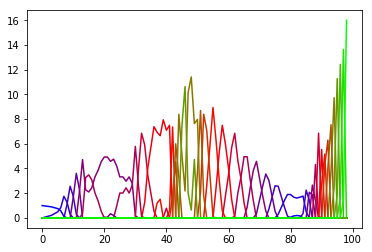

In [96]:
# MODIFY to allow curves for the amplitude envelopes amp_env:

# GENERATE THE RTcmix score !
def writesco(tones_dict,base_name,amp_env_array):
    # ====================
    score_name = base_name + '.sco'
    print(score_name)
    f_out = open("./" + score_name , 'w')
    # YOU MUST DELETE THE SOUND FILE BEFORE RUNNING (either with python or with -clobber )
    f_out.write("set_option(\"clobber = on\")\n")
    f_out.write("rtsetparams(44100, 2)\n")
    f_out.write("reset(44100)\n")
    f_out.write("load(\"WAVETABLE\")\n")

    output_string = 'rtoutput(\"' + base_name + '.wav\")\n'
    # don't need the brackets to make it an array !
    f_out.write(output_string)

    #f_out.write("waveform = maketable(\"wave\", 1000, 1.0, 0.4, 0.2)\n")
    f_out.write("waveform = maketable(\"wave\", 3000, 1.0, 0.2, 0.1)\n")
    #f_out.write("waveform = maketable(\"wave\", 1000, 1.0)\n")
    #f_out.write("ampenv = maketable(\"window\", 1000, \"hamming\")\n")
    # write out the score !
    # (start time, duration, amplitude, frequency, channel mix [0 left, 1.0 right],
    # table_handle (which waveform to use)

    # for now, constants:

    # reset(44100) makes it very very smooth...

    tab_han = 'waveform'

    times = tones_dict['times']
    notes = tones_dict['notes']
    durs = tones_dict['durs']
    amps = tones_dict['amps']
    pans = tones_dict['pans']

    for i,note_val in enumerate(notes):
        t_start = times[i]
        dur = durs[i]
        freq = note_val # coming in from enumerate
        amp = amps[i]
        pan = pans[i]
        # here you can subsample the envelopes if too complicated: 
        #amp_env_curve = env_ra[i,::40].tolist()
        #amp_env_curve = env_ra[i,::10].tolist()
        amp_env_curve = env_ra[i,::2].tolist()
        
        #table = maketable("literal", "nonorm", size, n1, n2, n3, n4 ...)
        #f_out.write("ampenv = maketable(\"window\", 1000, \"hamming\")\n")
        f_out.write('ampenv = maketable(\"literal\", \"nonorm\", '+ str(len(amp_env_curve)) +', ' + str(amp_env_curve).strip('[').strip(']') + ')\n')
        note_string = 'WAVETABLE(' + str(t_start) + ', ' \
                      + str(dur)  + ', ' + str(amp) + '*ampenv' + ', ' \
                      + str(freq)  + ', ' + str(pan)  + ', ' \
                      +  tab_han + ')\n'
        f_out.write(note_string)
    f_out.close()
    return score_name

amp_env_array = env_ra
score_name = writesco(tones_dict,base_name,amp_env_array)

for i in range(Nw):
    plt.plot(amp_env_array[i,:],color=colors[i])

In [97]:
cmix_cmd = 'CMIX < ' + score_name
print(cmix_cmd)

# the ! tells the notebook to run a command in the terminal
! pwd
! ls *.sco
# or if that doesnt work, try this: 
ls_output = sp.check_output(['pwd'])

print(ls_output)
# but THIS works better ! 
! pwd

runCMIX = sp.Popen(cmix_cmd, shell=True) # if can only be called from a shell, use shell=True
runCMIX.wait()
print("hopefully i just wrote your sound file; is it here?")
! ls *.wav

CMIX < test_BAdata_chSweep_Nwts16.sco
/Users/ben/githole/datamovies/1_codes
test_BAdata_chSweep_Nwts16.sco
b'/Users/ben/githole/datamovies/1_codes\n'
/Users/ben/githole/datamovies/1_codes
hopefully i just wrote your sound file; is it here?
test_BAdata_chSweep_Nwts16.wav


# Exercises
### Compose with heat and humidity, using the data from your group !: 
### 1) Make a new version of the notebook or use a script (copy and paste the parts you need)
### 2) compose one track for temp and one for humidity, using different but complementary methods (we will soon put these together with movies in stereo. 
### Please note the things in the code that you don't understand ! 